# Reconocimiento de señales de tránsito colombianas

Sergio Alejandro Diaz Pinilla

### Motivación
El reconocimiento de señales de tránsito, permitiría un desarrollo de las siguientes actividades.
- Asistencia del conductor
- Información para conducción autónoma.
- Cumplimiento de las señales de tránsito
Permitiendo así una mejor conducción en las vías y previniendo accidentes causados por ignorar las señales de tránsito.

### Contexto
Los ADAS  son un sistema que está diseñado para aumentar la seguridad de vehículo mediante mecanismos como informar al conductor de peligros o tomar el control de este en emergencias.
Uno  de  los  sistemas  que  usan  estos sistemas es el reconocimiento de señales (TSR) , para recopilar información de la carretera.

Uno  de  los  sistemas  que  usan  estos sistemas es el reconocimiento de señales (TSR) , para recopilar información de la carretera.
Los TSR se dividen en dos componentes,  el sistema detector y el reconocedor .

![TSR](notebook/TSR-example.png)

En colombia hay 4 tipos de señales de tránsito:
- Preventivas 
- Reglamentarias
- Informativas
- Señales del piso
Las señales de tránsito en colombia son regidas por el código nacional de tránsito.

Algunas de las señales de tránsito no tienen un buen mantenimiento o son vandalizadas.
Estas actividades pueden dificultar el reconocimiento de estas.

![sign-bad](notebook/sign-bad.png)

No existe base de datos de las imágenes (Señales en Colombia) por lo cual se recopilaron la imágenes de estas señales.

### Proceso
A continuación se vera la solución propuesta.
![proceso](notebook/proceso.png)

# LIBRERÍAS NECESARIAS 
- Python 2.7
- [Opencv 3](http://opencv.org/)
- [Scikit-learn](http://scikit-learn.org/)
- [Imutils](https://github.com/jrosebr1/imutils)
- [Numpy](http://www.numpy.org/)

RESULTADOS SALEN EN VENTANAS NO EN PLOTS

### Detección
Se aplica una segmentación con color en los espacios YUV y HSV para detectar los posibles candidatos a señal de tránsito, luego se hace una modificación morfológica a estos candidatos para eliminar ruido y mejorar los posibles candidatos, luego se extraen cada uno de estos candidatos y se pasan al proceso de segmentación.

In [1]:
from collections import deque
import numpy as np
import imutils
import cv2

"""
Clase de Deteccion
 img : imagen a buscar senal
 show: mostrar proceso
 debug: mostrar imagenes de debug
 half: solo tomar media imagen (parte derecha) - primeras pruebas ya no se usa
"""
class Detector:
    def __init__(self, img, show=False, debug=False, half=False):
        if not half:
            self.img = imutils.resize(img, width=600)
        else:
            self.img = imutils.resize(img[:, int(img.shape[1] / 2):img.shape[1]], width=200)
        self.draw = np.zeros_like(self.img)
        self.show = show
        self.debug = debug

        # YUV
        self.lower_redY = np.array([160])
        self.upper_redY = np.array([255])

        self.lower_red = (150, 30, 80)
        self.upper_red = (200, 200, 255)

        self.lower_yellow = (0, 50, 200)
        self.upper_yellow = (30,150,255)

    # Valida bordes para por si la senal esta en un borde    
    def validate_borders(self, cx1, cx2, cy1, cy2):
        if cx1 >= self.img.shape[1]:
            cx1 = self.img.shape[1] - 1

        if cx2 >= self.img.shape[1]:
            cx2 = self.img.shape[1] - 1

        if cy1 >= self.img.shape[0]:
            cy1 = self.img.shape[0] - 1

        if cy2 >= self.img.shape[0]:
            cy2 = self.img.shape[0] - 1
        # menor
        if cx1 < 0:
            cx1 = 0

        if cx2 < 0:
            cx2 = 0

        if cy1 < 0:
            cy1 = 0

        if cy2 < 0:
            cy2 = 0

        return cx1, cx2, cy1, cy2

    def detect(self):
        yuv = cv2.cvtColor(self.img, cv2.COLOR_BGR2YUV)
        hsi = cv2.cvtColor(self.img, cv2.COLOR_BGR2HLS)

        # YUV
        kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
        mask1 = cv2.inRange(hsi, self.lower_red, self.upper_red) + cv2.inRange(hsi, self.lower_yellow,self.upper_yellow)
        cv2.bitwise_and(mask1, mask1, mask=cv2.inRange(yuv[:, :, 2], self.lower_redY, self.upper_redY))
        mask = cv2.erode(mask1, kernel, iterations=1)
        mask = cv2.dilate(mask, kernel, iterations=5)

        cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
                                cv2.CHAIN_APPROX_SIMPLE)[-2]
        center = None
        th = None
        sign = None
        if len(cnts) > 0:
            # Busca el contorno mas grande en la mascara y le calcula el menor circulo que lo abarque y calcula el centroide
            c = max(cnts, key=cv2.contourArea)
            ((x, y), radius) = cv2.minEnclosingCircle(c)
            M = cv2.moments(c)
            center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))

            # Solo si el radio es radio del circulo es mayor que 10
            if radius > 10 and self.debug:
                cv2.circle(self.draw, (int(x), int(y)), int(radius),
                           (0, 255, 255), 2)
                cv2.circle(self.draw, center, 5, (0, 0, 255), -1)
            if radius >10:
                cx1 = int(center[0] - radius-0)
                cx2 = int(center[0] + radius+0)
                cy1 = int(center[1] - radius-0)
                cy2 = int(center[1] + radius+0)

                cx1, cx2, cy1, cy2 = self.validate_borders(cx1, cx2, cy1, cy2)
                sign = self.img[cy1:cy2, cx1:cx2]
                th = mask[cy1:cy2, cx1:cx2]

        if self.show:
            print("detect")
            cv2.imshow("IMG YUV", yuv)
            if mask is not None: cv2.imshow("MASK MORP", mask)
            cv2.imshow("MASK YUV", mask1)
            if sign is not None: cv2.imshow("Sign", sign)
            cv2.imshow("IMG", self.img)
            cv2.waitKey(0)
            cv2.destroyAllWindows()
        return sign, th
    # Detectar mas de una senal por imagen
    def multiple_detect(self):
        yuv = cv2.cvtColor(self.img, cv2.COLOR_BGR2YUV)
        hsi = cv2.cvtColor(self.img, cv2.COLOR_BGR2HLS)
        # YUV
        kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
        mask1 = cv2.inRange(hsi, self.lower_red, self.upper_red) + cv2.inRange(hsi, self.lower_yellow,
                                                                               self.upper_yellow)
        cv2.bitwise_and(mask1, mask1, mask=cv2.inRange(yuv[:, :, 2], self.lower_redY, self.upper_redY))
        mask = cv2.erode(mask1, kernel, iterations=1)
        mask = cv2.dilate(mask, kernel, iterations=5)

        cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
                                cv2.CHAIN_APPROX_SIMPLE)[-2]
        center = None
        th = []
        sign = []
        if len(cnts) > 0:
            for i in cnts:
                ((x, y), radius) = cv2.minEnclosingCircle(i)
                M = cv2.moments(i)
                center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))

                # only proceed if the radius meets a minimum size
                if 10 < radius < 200:
                    # draw the circle and centroid on the frame,
                    # then update the list of tracked points
                    cv2.circle(self.draw, (int(x), int(y)), int(radius),
                               (0, 255, 255), 2)
                    cv2.circle(self.draw, center, 5, (0, 0, 255), -1)
                    cv2.putText(self.draw, str(radius),center,cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 2)

                if 10 < radius < 200:
                    cx1 = int(center[0] - radius - 20)
                    cx2 = int(center[0] + radius + 20)
                    cy1 = int(center[1] - radius - 20)
                    cy2 = int(center[1] + radius + 20)

                    cx1, cx2, cy1, cy2 = self.validate_borders(cx1, cx2, cy1, cy2)
                    # sign = cv2.bitwise_and(self.img[cy1:cy2,cx1:cx2],self.img[cy1:cy2,cx1:cx2],mask = mask[cy1:cy2,cx1:cx2])
                    sign.append(self.img[cy1:cy2, cx1:cx2])
                    th.append(mask[cy1:cy2, cx1:cx2])

        return sign, th
    # Detectar senal en video
    def video_test(self):
        yuv = cv2.cvtColor(self.img, cv2.COLOR_BGR2YUV)
        hsi = cv2.cvtColor(self.img, cv2.COLOR_BGR2HLS)
        # YUV
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
        mask1 = cv2.inRange(hsi, self.lower_red, self.upper_red)+ cv2.inRange(hsi, self.lower_yellow, self.upper_yellow)
        cv2.bitwise_and(mask1, mask1, mask=cv2.inRange(yuv[:,:,2], self.lower_redY, self.upper_redY))

        mask = cv2.erode(mask1, kernel, iterations=1)
        mask = cv2.dilate(mask, kernel, iterations=5)
        cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
                                cv2.CHAIN_APPROX_SIMPLE)[-2]
        center = None
        th = None
        sign = None
        if len(cnts) > 0:
            for i in cnts:
                ((x, y), radius) = cv2.minEnclosingCircle(i)
                M = cv2.moments(i)
                center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))

                if 15 < radius < 30:
                    cv2.circle(self.draw, (int(x), int(y)), int(radius),
                               (0, 255, 255), 2)
                    cv2.circle(self.draw, center, 5, (0, 0, 255), -1)
                    cv2.putText(self.draw, str(radius),center,cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 2)

                if 15 < radius < 30:
                    cx1 = int(center[0] - radius - 0)
                    cx2 = int(center[0] + radius + 0)
                    cy1 = int(center[1] - radius - 0)
                    cy2 = int(center[1] + radius + 0)

                    cx1, cx2, cy1, cy2 = self.validate_borders(cx1, cx2, cy1, cy2)
                    sign = self.img[cy1:cy2, cx1:cx2]
                    th = mask[cy1:cy2, cx1:cx2]
        if self.debug:
            cv2.imshow("IMG YUV", yuv)
            if mask is not None: cv2.imshow("MASK MORP", mask)
            cv2.imshow("MASK YUV", mask1)
        return sign, th

"""
Funcion de test
one = Si solo queremos detectar en una imagen o en multiple imagenes
"""
def test(one=True):
    total = 0
    imgs = []
    if one:
        print("Detecting:")
        img_file = "./Data/Preventivas/STC-PV-30.jpg"
        # img_file = "./Data/Mixtas/STC-MX-30.jpg"
        # img_file = "./Data/Reglamentarias/STC-RG-17.jpg"
        sign = cv2.imread(img_file, 1)
        d = Detector(sign, show=True, debug=True)
        s,th = d.multiple_detect()
        cv2.imshow("img",cv2.bitwise_or(d.img, d.draw))
        for j in s:
            cv2.imshow("img" + str(total), j)

            total += 1
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    else:
        for i in range(1, 45):
            #img_file = "./Data/Preventivas/STC-PV-"+str(i)+".jpg"
            #img_file = "./Data/Reglamentarias/STC-RG-" + str(i) + ".jpg"
            img_file = "./Data/Mixtas/STC-MX-"+ str(i) +".jpg"
            sign = cv2.imread(img_file, 1)
            d = Detector(sign, show=False, debug=False)
            s, th = d.multiple_detect()
            for j in s:
                #cv2.imwrite('./training/PV/Sign-Preventivas-'+str(i)+'-'+str(total)+'.jpg', imutils.resize(j, width=100))
                cv2.imwrite('./training/MX/Sign-Mixtas-'+str(i)+'-'+str(total)+'.jpg', imutils.resize(j, width=100))
                #cv2.imshow("img" + str(total), imutils.resize(j, width=100))
                # imgs.append((str(i)+"-"+str(total), j))
                total += 1
                print ("1")
            else:
                print ("0")
        print ("Detected:", str(total))

        #cv2.waitKey(0)
        #cv2.destroyAllWindows()
if __name__ == "__main__":
    test()

Detecting:


Resultado reglamentarias
![proceso](notebook/Det-1.png)
Resultados preventivas
![proceso](notebook/Det-2.png)

### Segmentación
Con las señales ya aisladas se procede al segmentar esta mediante el algoritmo de Watershed para obtener las posibles zonas en que está dividida la señal.

In [4]:
import numpy as np
import imutils
import cv2
from Detect import Detector
from imutils import paths

"""
Clase de Segmentacion
 img : senal a segmentar
"""
class Segmentor:
    def __init__(self, img):
        self.origi = imutils.resize(img, width=100)
        self.img = self.origi.copy()
        self.th = np.zeros_like(self.img)

        self.th[:, :, 0] = cv2.adaptiveThreshold(cv2.cvtColor(self.img, cv2.COLOR_BGR2GRAY), 255,
                                                 cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
        kernel = np.ones((2, 2), np.uint8)
        self.th[:, :, 0] = cv2.morphologyEx(self.th[:, :, 0], cv2.MORPH_CLOSE, kernel)
        self.th[:, :, 1] = self.th[:, :, 2] = self.th[:, :, 0]
        self.kp = None
        self.kpimg = np.zeros_like(img)
        self.segmented = np.zeros_like(img)
        self.fast = cv2.FastFeatureDetector_create()
    # Algoritmo watershed
    def watershed(self, debug=False):
        kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
        opening = cv2.morphologyEx(self.th[:, :, 0], cv2.MORPH_OPEN, kernel, iterations=2)

        # sure background area
        sure_bg = cv2.dilate(self.th[:, :, 0], kernel, iterations=3)

        # Finding sure foreground area
        dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
        ret, sure_fg = cv2.threshold(dist_transform, 0.1 * dist_transform.max(), 255, 0)

        # Finding unknown region
        sure_fg = np.uint8(sure_fg)

        unknown = cv2.subtract(sure_bg, sure_fg)

        # Marker labelling
        ret, markers = cv2.connectedComponents(sure_fg)

        # Add one to all labels so that sure background is not 0, but 1
        markers = markers + 1

        # Now, mark the region of unknown with zero
        markers[unknown == 255] = 0

        markers = cv2.watershed(self.img, markers)
        self.add_color(markers)
        if debug:
            cv2.imshow("fg", unknown)
            cv2.imshow("op", opening)
            cv2.imshow("o3", sure_bg)
    # Colorear watershed
    def add_color(self, markers):
        self.img[markers == -1] = [255, 255, 255]
        self.img[markers == 1] = [255, 0, 0]
        self.img[markers == 2] = [0, 50, 0]
        self.img[markers == 3] = [0, 0, 255]
        self.img[markers == 4] = [255, 255, 0]
        self.img[markers == 5] = [0, 255, 255]
        self.img[markers == 6] = [255, 0, 255]

        self.img[markers == 7] = [125, 0, 0]
        self.img[markers == 8] = [0, 125, 0]
        self.img[markers == 9] = [0, 0, 125]
        self.img[markers == 10] = [125, 125, 0]
        self.img[markers == 11] = [0, 125, 125]
        self.img[markers == 12] = [125, 0, 125]

        self.img[markers == 13] = [255, 255, 255]
        self.img[markers == 14] = [255, 0, 0]
        self.img[markers == 15] = [0, 255, 0]
        self.img[markers == 16] = [0, 0, 255]
        self.img[markers == 17] = [255, 255, 0]
        self.img[markers == 18] = [0, 255, 255]
        self.img[markers == 19] = [255, 0, 255]
    # Extraer keypoints con FAST
    def keypoints(self, otsu=False):
        if not otsu :self.kp = self.fast.detect(self.th, None)
        else: self.kp = self.fast.detect(self.th, None)
        self.kpimg = cv2.drawKeypoints(self.th, self.kp,None, color=(0,255,0))
    # Transormar los Keypoints de FAST en descriptores, se agregan los momentos y los momentos de HU
    def descriptors(self):
        if self.kp is None:
            return []
        else:
            data = []
            for j in range(15):
                data.append(self.kp[j].response)

            moments = cv2.moments(self.th[:,:,0])
            data = np.append(data,cv2.HuMoments(moments).flatten())
            return data

"""
Funcion de Test
 one : Solo una imagen o un grupo de imagenes
 complete : mostrar deteccion tambien
"""
def test(one= True, complete = True):
    total = 0
    imgs = []
    if one:
        print("Detecting:")
        file = "./Data/Reglamentarias/STC-RG-3.jpg"
        sign = cv2.imread(file,1)
        d = Detector(sign,show=complete, debug=complete)
        s, th = d.detect()
        print("Segment")
        seg = Segmentor(s)
        seg.watershed()
        seg.keypoints()
        seg.descriptors()
        res = np.concatenate((seg.origi,seg.th, seg.img, seg.kpimg), axis=1)
        cv2.imshow("res", res)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    else:
        for i in range(1,45):
            #file = "./Data/Preventivas/STC-PV-"+str(i)+".jpg"
            file = "./Data/Reglamentarias/STC-RG-" + str(i) + ".jpg"
            #file = "./Data/Mixtas/STC-MX-"+ str(i) +".jpg"
            sign = cv2.imread(file,1)
            d = Detector(sign,show=complete)
            s,th = d.detect()
            if s is not None :
                total +=1
                imgs.append((i, s,th))

        print ("Detected:", str(total))
        for i in range(1,len(imgs)-1):
            seg = Segmentor(imgs[i][1], imgs[i][2])
            seg.watershed()
            seg.keypoints()
            res = np.concatenate((seg.origi,seg.th, seg.img, seg.kpimg), axis=1)
            cv2.imshow("img"+str(imgs[i][0]), res)
            print (str(imgs[i][0]))

        cv2.waitKey(0)
        cv2.destroyAllWindows()
if __name__ == "__main__":
    test(True)

Detecting:
Segment


Resultados segmentación
![proceso](notebook/Seg-1.png)

### Características y Clasificación
Se utilizaron los keypoints que se obtienen con el algoritmo FAST y el color de la señal. Estas caracteristicas son reducidas con LDA a solo 2 caracteristicas.
Se usaron dos clasificadores, una máquina de vector de soporte y una red neuronal sencilla para el proceso de clasificación y así comparar resultados con dos clasificadores.

Para automatizar este proceso lo mas posible se creo una clase de entrenamiento.


Train LDA
LDA- complete


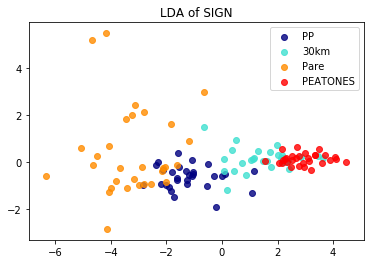

Train SVM


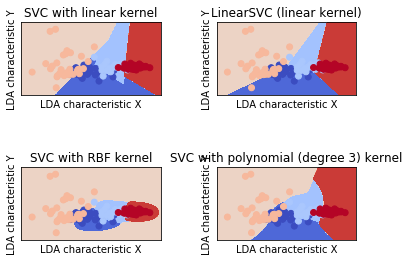

Training NN
End NN
Saving config
Save complete


In [2]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.externals import joblib
import cv2
from imutils import paths
from Segmentation import Segmentor
import itertools
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')
"""
Clase Training
Siempre se incluye los datos de entrenamiento por si se quiere re-entrenar una nueva

sings = Arreglo con las senales que se quiere entrenar ej:['class1','class2']
folders = Arreglo con ruta de las carpetas con las imagenes de entrenamiento
load = Para cargar el entrenamiento previo en caso de que se tenga
"""

class Training:
    def __init__(self, sings = None, folders= None, load = False):
        if sings != None and folders != None:
            self.signs = sings
            self.trainig_paths = []
            for i in range(len(folders)):
                self.trainig_paths.append("./training/" + folders[i] + "/")
            self.train_lda_x = []
            self.train_lda_y = []
            self.LDA = None
            self.training_data = []
            self.SVM = None
            self.NN = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
            self.NNNOFIT = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
            if load:
                self.load_config()
        else:
            print (
            "Incluir arreglo de clases y arreglo de datos de entrenamiento\n ['clase1','clase2'],['./folder/folderClass1', './folder/folderClass2']")

    def save_config(self):
        print("Saving config")
        joblib.dump(self.SVM, './configuration/SVM.pkl')
        joblib.dump(self.NN, './configuration/NN.plk')
        joblib.dump(self.LDA, './configuration/LDA.plk')
        joblib.dump(self.NNNOFIT, './configuration/NNNOFIT.plk')
        print("Save complete")

    def load_config(self):
        self.SVM = joblib.load('./configuration/SVM.pkl')
        self.NN = joblib.load('./configuration/NN.plk')
        self.LDA = joblib.load('./configuration/LDA.plk')
        self.NNNOFIT = joblib.load('./configuration/NNNOFIT.plk')
        print ("Load Complete")

    def train_NN(self):
        print("Training NN")
        self.NNNOFIT.fit(self.train_lda_x, self.train_lda_y)
        self.NN.fit(self.training_data, self.train_lda_y)
        print("End NN")
    def train_data(self):
        for i in range(len(self.trainig_paths)):
            for imagePath in paths.list_images(self.trainig_paths[i]):
                s = cv2.imread(imagePath, 1)
                seg = Segmentor(s)
                seg.keypoints()
                self.train_lda_x.append(seg.descriptors())
                self.train_lda_y.append(self.signs.index(self.signs[i]))
                res = np.concatenate((seg.origi, seg.th, seg.img, seg.kpimg), axis=1)
        self.train_lda_x = np.array(self.train_lda_x)
        self.train_lda_y = np.array(self.train_lda_y)

    def draw_training(self):
        colors = ['navy', 'turquoise', 'darkorange', 'red', 'green']
        for color, i, target_name in zip(colors, [0, 1,2,3,4], self.signs):
            plt.scatter(self.training_data[self.train_lda_y == i, 0], self.training_data[self.train_lda_y == i, 1], alpha=.8, color=color,
                        label=target_name)
        plt.legend(loc='best', shadow=False, scatterpoints=1)
        plt.title('LDA of SIGN')
        plt.show()

    def train_lda(self):
        # LDA
        print("Train LDA")
        self.LDA = LinearDiscriminantAnalysis(n_components=2)
        self.training_data = self.LDA.fit(self.train_lda_x, self.train_lda_y).transform(self.train_lda_x)
        print("LDA- complete")

    def train_SVG(self):
        print("Train SVM")
        X = self.training_data  
        y = self.train_lda_y
        h = .02  # step size in the mesh
        C = 0.5  # SVM regularization parameter
        svc = svm.SVC(kernel='linear', C=C).fit(X, y)
        rbf_svc = svm.SVC(kernel='rbf', gamma=0.7, C=C).fit(X, y)
        poly_svc = svm.SVC(kernel='poly', degree=3, C=C).fit(X, y)
        lin_svc = svm.LinearSVC(C=C).fit(X, y)
        self.SVM = svc
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))

        # title for the plots
        titles = ['SVC with linear kernel',
                  'LinearSVC (linear kernel)',
                  'SVC with RBF kernel',
                  'SVC with polynomial (degree 3) kernel']


        for i, clf in enumerate((svc, lin_svc, rbf_svc, poly_svc)):
            # Plot the decision boundary. For that, we will assign a color to each
            # point in the mesh [x_min, x_max]x[y_min, y_max].
            plt.subplot(2, 2, i + 1)
            plt.subplots_adjust(wspace=0.4, hspace=1)

            Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

            # Put the result into a color plot
            Z = Z.reshape(xx.shape)
            plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm)

            # Plot also the training points
            plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)
            plt.xlabel('LDA characteristic X')
            plt.ylabel('LDA characteristic Y')
            plt.xlim(xx.min(), xx.max())
            plt.ylim(yy.min(), yy.max())
            plt.xticks(())
            plt.yticks(())
            plt.title(titles[i])

        plt.show()

    def reduce_kp(self, kp):
        return self.LDA.transform(kp)

    def plot_confusion_matrix(self, cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')

        print(cm)

        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

    def confucion(self,y_test,y_pred, class_names, title):
        cnf_matrix = confusion_matrix(y_test, y_pred)
        np.set_printoptions(precision=2)

        # Plot non-normalized confusion matrix
        plt.figure()
        self.plot_confusion_matrix(cnf_matrix, classes=class_names,
                              title=title+', without normalization')
        plt.figure()
        self.plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                              title=title+' Normalized confusion matrix')
        plt.show()

"""
funcion test
train = si se quiere cargar una red ya entrenada
"""
def test(train):
    if train:
        tra = Training(["PP", "30km", "Pare", "PEATONES"], ["Sign/pp", "Sign/V", "Sign/P", "Sign/s"])
        tra.train_data()
        tra.train_lda()
        tra.draw_training()
        tra.train_SVG()
        tra.train_NN()
        tra.save_config()
    else:
        tra = Training(["PP", "30km", "Pare", "PEATONES","Giro"], ["Sign/pp", "Sign/V", "Sign/P", "Sign/peaton","Sign/pt"], True)
        print (tra.SVM.predict([[-1.,2.]]))


if __name__ == "__main__":
    test(True)

Load Complete
Matrix
Confusion matrix, without normalization
[[8 0 2 0]
 [0 7 0 3]
 [3 0 7 0]
 [0 3 0 7]]
Normalized confusion matrix
[[ 0.8  0.   0.2  0. ]
 [ 0.   0.7  0.   0.3]
 [ 0.3  0.   0.7  0. ]
 [ 0.   0.3  0.   0.7]]


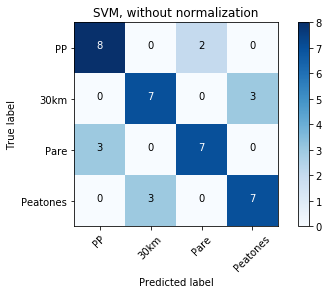

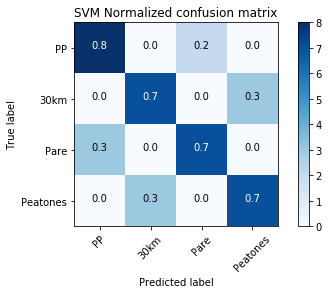

Confusion matrix, without normalization
[[7 1 2 0]
 [1 5 0 4]
 [2 0 8 0]
 [0 2 0 8]]
Normalized confusion matrix
[[ 0.7  0.1  0.2  0. ]
 [ 0.1  0.5  0.   0.4]
 [ 0.2  0.   0.8  0. ]
 [ 0.   0.2  0.   0.8]]


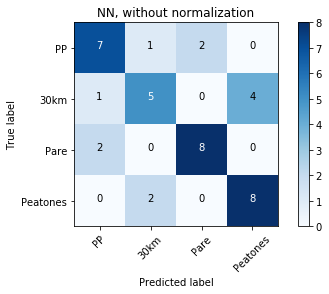

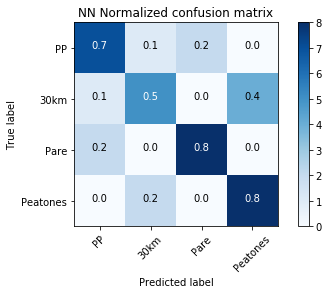

In [1]:
import numpy as np
import cv2
import imutils
from imutils import paths
from Detect import Detector
from Segmentation import Segmentor
from Training import Training
import warnings
warnings.filterwarnings('ignore')

ans = ["PP","30km","Pare","Peatones"]
ansdata = []
deducSVM = []
deducNN = []
deducNNNOFIT = []
debug = False
trainig_paths = ["./TestData/PP-test","./TestData/V-test", "./TestData/P-test", "./TestData/S-test"]


tra = Training(["PP","30km","Pare","PEATONES"],["Sign/pp", "Sign/V", "Sign/P", "Sign/peaton"], True)
def draw():
    if res == 0:
        cv2.putText(classifier, "prohibido parquear", (0, int(sign.shape[1] / 2)), cv2.FONT_HERSHEY_PLAIN, 2,
                    (0, 0, 255), 2)
    if res == 1:
        cv2.putText(classifier, "Limite velocidad", (0, int(sign.shape[1] / 2)), cv2.FONT_HERSHEY_PLAIN, 2, (0, 0, 255),
                    2)
    if res == 2:
        cv2.putText(classifier, "Pare", (0, int(sign.shape[1] / 2)), cv2.FONT_HERSHEY_PLAIN, 2, (0, 0, 255), 2)
    if res == 3:
        cv2.putText(classifier, "Peatones", (0, int(sign.shape[1] / 2)), cv2.FONT_HERSHEY_PLAIN, 2, (0, 0, 255), 2)

    if res2 == 0:
        cv2.putText(classifier, "prohibido parquear", (0, 50), cv2.FONT_HERSHEY_PLAIN, 2, (255, 0, 255), 2)
    if res2 == 1:
        cv2.putText(classifier, "Limite velocidad", (0, 50), cv2.FONT_HERSHEY_PLAIN, 2, (255, 0, 255), 2)
    if res2 == 2:
        cv2.putText(classifier, "Pare", (0, 50), cv2.FONT_HERSHEY_PLAIN, 2, (255, 0, 255), 2)
    if res2 == 3:
        cv2.putText(classifier, "Peatones", (0, 50), cv2.FONT_HERSHEY_PLAIN, 2, (255, 0, 255), 2)
    init = 70
    probs[0] = np.around(probs[0], decimals=4)
    if (probs != None):
        for i in range(len(probs[0])):
            text = ""
            if i == 0:
                text = "prohibido parquear"
            if i == 1:
                text = "Limite velocidad"
            if i == 2:
                text = "Pare"
            if i == 3:
                text = "Peatones"
            cv2.putText(classifier, text + ": " + str(probs[0][i]), (0, init), cv2.FONT_HERSHEY_PLAIN, 2, (255, 0, 255),
                        2)
            init += 20

for i in range(len(trainig_paths)):
    for imagePath in paths.list_images(trainig_paths[i]):
        ansdata.append(i)
        sign = cv2.imread(imagePath, 1)
        sign = imutils.resize(sign, width=600)
        classifier = np.zeros_like(sign)
        cv2.putText(classifier, "RED NEURONAL", (0, 30),
                    cv2.FONT_HERSHEY_PLAIN, 2, (0, 0, 255), 2)
        cv2.putText(classifier, "SVM-Linear", (0, int(sign.shape[1] / 2) - 20),
                    cv2.FONT_HERSHEY_PLAIN, 2, (0, 0, 255), 2)

        seg = Segmentor(sign)
        seg.watershed()
        seg.keypoints()
        if len(seg.kp) > 15:
            descriptors = seg.descriptors()
            res = np.concatenate((seg.origi, seg.th, seg.img, seg.kpimg), axis=1)
            if debug : 
                cv2.imshow("img"+imagePath,sign)
                cv2.imshow("res"+imagePath, res)
            reduc = tra.LDA.transform(descriptors)
            res = tra.SVM.predict(reduc)
            deducSVM.append(res[0])
            res2 = tra.NN.predict(reduc)
            deducNN.append(res2[0])
            res3 = tra.NNNOFIT.predict(descriptors)
            deducNNNOFIT.append(res3[0])
            probs = tra.NN.predict_proba(reduc)
            if debug : draw()

        if debug : cv2.imshow("Prediction" + imagePath, classifier)
if debug :
    cv2.waitKey(0)
    cv2.destroyAllWindows()
print("Matrix")
tra.confucion(ansdata,deducSVM,ans,"SVM")
tra.confucion(ansdata,deducNN,ans,"NN")

### Video
Aca la demo con un video y con la web-cam

In [1]:
import numpy as np
import cv2
import imutils
from Detect import Detector
from Segmentation import Segmentor
from Training import Training
import warnings
warnings.filterwarnings('ignore')

cap = cv2.VideoCapture("./video/vid2-2.mp4")
debug = True
tra = Training(["PP","30km","Pare","PEATONES"],["Sign/pp", "Sign/V", "Sign/P", "Sign/peaton"], True)



while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()
    frame = imutils.resize(frame, width=600)
    classifier = np.zeros_like(frame)
    cv2.putText(classifier, "RED NEURONAL", (0, 30),
                cv2.FONT_HERSHEY_PLAIN, 2, (0, 0, 255), 2)
    cv2.putText(classifier, "SVM-Linear", (0, int(frame.shape[1] / 2)-20),
                cv2.FONT_HERSHEY_PLAIN, 2, (0, 0, 255), 2)
    # Our operations on the frame come here
    d = Detector(frame, show=False, debug=False)
    s, th = d.video_test()
    if s is not None:
        seg = Segmentor(s)
        seg.watershed()
        seg.keypoints()
        if len(seg.kp) > 15:
            descriptors = seg.descriptors()
            res = np.concatenate((seg.origi, seg.th, seg.img, seg.kpimg), axis=1)
            cv2.imshow("img",s)
            cv2.imshow("res", res)
            reduc = tra.LDA.transform(descriptors)
            res = tra.SVM.predict(reduc)
            res2 = tra.NN.predict(reduc)
            probs = tra.NN.predict_proba(reduc)
            if res == 0:
                cv2.putText(classifier, "prohibido parquear" ,(0,int(frame.shape[1]/2)), cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 255), 2)
            if res == 1:
                cv2.putText(classifier, "Limite velocidad" ,(0,int(frame.shape[1]/2)), cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 255), 2)
            if res == 2:
                cv2.putText(classifier, "Pare" ,(0,int(frame.shape[1]/2)), cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 255), 2)
            if res == 3:
                cv2.putText(classifier, "Peatones" ,(0,int(frame.shape[1]/2)), cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 255), 2)

            if res2 == 0:
                cv2.putText(classifier, "prohibido parquear" ,(0,50), cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 2)
            if res2 == 1:
                cv2.putText(classifier, "Limite velocidad" ,(0,50), cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 2)
            if res2 == 2:
                cv2.putText(classifier, "Pare" ,(0,50), cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 2)
            if res2 == 3:
                cv2.putText(classifier, "Peatones" ,(0,50), cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 2)
            init = 70
            probs[0] = np.around(probs[0], decimals=4)
            if(probs != None):
                for i in range(len(probs[0])):
                    text = ""
                    if i == 0:
                        text = "prohibido parquear"
                    if i == 1:
                        text = "Limite velocidad"
                    if i == 2:
                        text = "Pare"
                    if i == 3:
                        text = "Peatones"
                    cv2.putText(classifier, text+": "+str(probs[0][i]), (0, init), cv2.FONT_HERSHEY_PLAIN, 2, (255, 0, 255), 2)
                    init += 20
    res_vid = np.concatenate((cv2.bitwise_or(d.img,d.draw), classifier), axis=1)
    cv2.imshow("vid",res_vid )

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

Load Complete


KeyboardInterrupt: 

### Web-cam
Problemas con detecion de piel de persona

In [3]:
import numpy as np
import cv2
import imutils
from Detect import Detector
from Segmentation import Segmentor
from Training import Training
import warnings
warnings.filterwarnings('ignore')
cap = cv2.VideoCapture(0)

debug = True
tra = Training(["PP","30km","Pare","PEATONES"],["Sign/pp", "Sign/V", "Sign/P", "Sign/peaton"], True)



while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()
    frame = imutils.resize(frame, width=600)
    classifier = np.zeros_like(frame)
    cv2.putText(classifier, "RED NEURONAL", (0, 30),
                cv2.FONT_HERSHEY_PLAIN, 2, (0, 0, 255), 2)
    cv2.putText(classifier, "SVM-Linear", (0, int(frame.shape[1] / 2)-20),
                cv2.FONT_HERSHEY_PLAIN, 2, (0, 0, 255), 2)
    # Our operations on the frame come here
    d = Detector(frame, show=False, debug=False)
    s, th = d.video_test()
    if s is not None:
        seg = Segmentor(s)
        seg.watershed()
        seg.keypoints()
        if len(seg.kp) > 15:
            descriptors = seg.descriptors()
            res = np.concatenate((seg.origi, seg.th, seg.img, seg.kpimg), axis=1)
            cv2.imshow("img",s)
            cv2.imshow("res", res)
            reduc = tra.LDA.transform(descriptors)
            res = tra.SVM.predict(reduc)
            res2 = tra.NN.predict(reduc)
            probs = tra.NN.predict_proba(reduc)
            if res == 0:
                cv2.putText(classifier, "prohibido parquear" ,(0,int(frame.shape[1]/2)), cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 255), 2)
            if res == 1:
                cv2.putText(classifier, "Limite velocidad" ,(0,int(frame.shape[1]/2)), cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 255), 2)
            if res == 2:
                cv2.putText(classifier, "Pare" ,(0,int(frame.shape[1]/2)), cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 255), 2)
            if res == 3:
                cv2.putText(classifier, "Peatones" ,(0,int(frame.shape[1]/2)), cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 255), 2)

            if res2 == 0:
                cv2.putText(classifier, "prohibido parquear" ,(0,50), cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 2)
            if res2 == 1:
                cv2.putText(classifier, "Limite velocidad" ,(0,50), cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 2)
            if res2 == 2:
                cv2.putText(classifier, "Pare" ,(0,50), cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 2)
            if res2 == 3:
                cv2.putText(classifier, "Peatones" ,(0,50), cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 2)
            init = 70
            probs[0] = np.around(probs[0], decimals=4)
            if(probs != None):
                for i in range(len(probs[0])):
                    text = ""
                    if i == 0:
                        text = "prohibido parquear"
                    if i == 1:
                        text = "Limite velocidad"
                    if i == 2:
                        text = "Pare"
                    if i == 3:
                        text = "Peatones"
                    cv2.putText(classifier, text+": "+str(probs[0][i]), (0, init), cv2.FONT_HERSHEY_PLAIN, 2, (255, 0, 255), 2)
                    init += 20
    res_vid = np.concatenate((cv2.bitwise_or(d.img,d.draw), classifier), axis=1)
    cv2.imshow("vid",res_vid )

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

Load Complete


Resultado video
![proceso](notebook/Vid.png)

### Concluciones
Se cumplió el objetivo general de crear un clasificador de señales de transito colombianas, esto se realizo usando diferentes técnicas de visión de maquina. Aunque se tenían pocas imágenes para hacer el entrenamiento se obtuvieron buenos resultados, pero esta muy limitado el numero de clases, para mejorar esto se debería mejorar y aumentar la etapa de extracción de características. Por ultimo para evitar el ruido detectado como paredes de colores, personas con ropa de colores, se podría agregar otra etapa en la cual se tenga un pequeño clasificador que rachase las imágenes que no entran en la categoría de señal de transito eliminando la clasificación final de ruido.

### Archivos
- DATA imagenes de muestra inicial (completa)
- TESTDATA imagenes para desempeño
- Training/sign imagenes de entrenamiento
- *.py clases del proyecto
- video.py pureba completa
